# Perform a more intellegent on 'Zhou et al. Band gap data'

## Import the libraries we will be using

In [1]:
# read in data with pandas
import pandas as pd
# use numpy for vector and matrix operations
import numpy as np

# composition is a custom made python file that generates composition-based feature vectors (CBFV)
import composition
# utils is a custom made python file that has some useful functions
import utils

# make nice figures
import matplotlib.pyplot as plt
# machine learnign algorithms
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
# preprocessing for the features
from sklearn.preprocessing import StandardScaler, Normalizer
# feature reduction
from sklearn.decomposition import PCA
# import model selection tools
from sklearn.model_selection import cross_validate, cross_val_score,\
                                    cross_val_predict, learning_curve, \
                                    GridSearchCV, KFold
# grab metrics to evaluate our models
from sklearn.metrics import confusion_matrix, classification_report,\
                            r2_score, mean_squared_error

In [2]:
# read in band gap data from Zhou et al. publication:
# J. Phys. Chem. Lett., 2018, 9 (7), pp 1668–1673
#DOI: 10.1021/acs.jpclett.8b00124
#Publication Date (Web): March 13, 2018
df_band_gap = pd.read_excel('band_gap_data/jz8b00124_si_002.xlsx')

# excel sheet is edited to fix formula "GaAs0.1P0.9G1128" to "GaAs0.1P0.9"
df_band_gap.replace("GaAs0.1P0.9G1128", "GaAs0.1P0.9", inplace=True)

In [21]:
df_train['formula'].value_counts()

CdS                         22
CdSe                        20
ZnS                         18
GaSe                        18
GaAs                        16
InSb                        15
ZnO                         15
As2S3                       14
TlBr                        14
GaSb                        14
CdSb                        14
InP                         14
PbTe                        13
ZnSe                        13
AlSb                        12
CuCl                        12
InAs                        12
ZnTe                        12
InSe                        12
PbS                         12
Ag3SbS3                     11
PbSe                        11
Mg2Sn                       11
AlP                         11
CdTe                        11
TlSe                        10
GaTe                        10
GaS                         10
CdGeAs2                      9
GeS                          9
                            ..
Na2SO4                       1
Hf2Hg   

In [3]:
## take the average of duplicate composition entries
df_band_gap = df_band_gap.groupby('formula').mean().reset_index()

df_band_gap.shape

(6354, 2)

In [17]:
# split the data into a training and test set
df_train = df_band_gap.sample(frac=0.75, random_state=1)
df_test = df_band_gap[~df_band_gap.index.isin(list(df_train.index.values))].sample(frac=1, random_state=1)

In [18]:
# rename columns for use with feature generation
df_train.columns = ['formula', 'target']
df_test.columns = ['formula', 'target']

Text(0, 0.5, '# of instances')

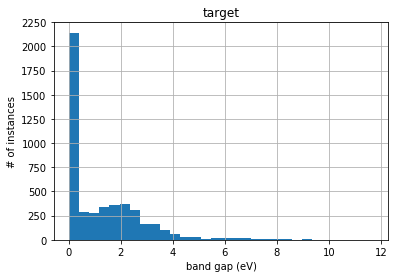

In [19]:
df_train.hist(bins=30)
plt.xlabel('band gap (eV)')
plt.ylabel('# of instances')

Text(0, 0.5, '# of instances')

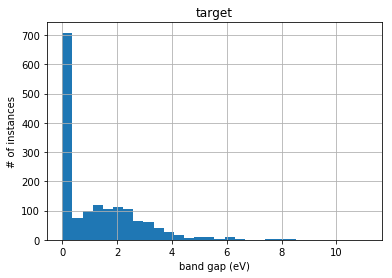

In [20]:
df_test.hist(bins=30)
plt.xlabel('band gap (eV)')
plt.ylabel('# of instances')

**Upon closer inspection of the data, we now see there are two issues we need to address with our data**

1. The data contain duplicate formulae entries. 
    - *This means that the same formula could end up in both training, validation and test sets. This will give us an overly optimisitc model.*
2. The data we are trying to learn contain metals & non-metals. 
    - *This has the effect of giving us very imbalanced data.*


To correct for these two issues we will
1. take the average band gap for duplicate composition entries
2. separate remove the metal band gaps from our regression


In [10]:
print('train size before removing metals:', df_train.shape)
print('test size before removing metals:', df_test.shape)

## separate the metal and non-metal compounds
df_train = df_train[df_train['target'] > 0]
df_test = df_test[df_test['target'] > 0]

print('train size after removing metals:', df_train.shape)
print('test size after removing metals:', df_test.shape)

train size before removing duplicates & metals: (4766, 2)
test size before removing duplicates & metals: (1588, 2)
train size after removing duplicates & metals: (1946, 2)
test size after removing duplicates & metals: (774, 2)


Text(0, 0.5, '# of instances')

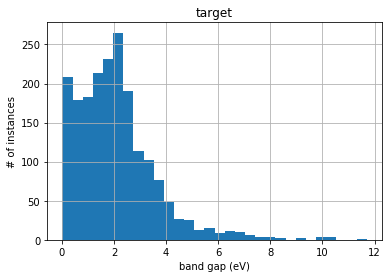

In [11]:
df_train.hist(bins=30)
plt.xlabel('band gap (eV)')
plt.ylabel('# of instances')

Text(0, 0.5, '# of instances')

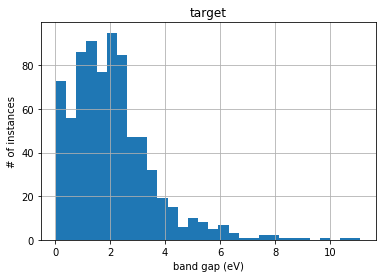

In [12]:
df_test.hist(bins=30)
plt.xlabel('band gap (eV)')
plt.ylabel('# of instances')

In [13]:
X_train, y_train, formula_train = composition.generate_features(df_train)
X_test, y_test, formula_test = composition.generate_features(df_test)

The element: Eu from formula Ba3EuP3O12 is not currently supported in our database
The element: Eu from formula Eu1.83Ta15O32 is not currently supported in our database
The element: Eu from formula Eu2Ga2GeS7 is not currently supported in our database
The element: Eu from formula Eu2O3 is not currently supported in our database
The element: Eu from formula Eu2Se3 is not currently supported in our database
The element: Eu from formula Eu2SnSe5 is not currently supported in our database
The element: Eu from formula Eu3In2P4 is not currently supported in our database
The element: Eu from formula Eu3P2 is not currently supported in our database
The element: Eu from formula Eu3S4 is not currently supported in our database
The element: Eu from formula Eu3Sb4Se9 is not currently supported in our database
The element: Eu from formula Eu3Se4 is not currently supported in our database
The element: Eu from formula Eu4Te7 is not currently supported in our database
The element: Eu from formula Eu7G

In [ ]:
# Initialize a "LinearRegression" object. This will allow us to do a simple linear regression on the data
lr = LinearRegression()
cv = KFold(n_splits=5, shuffle=True, random_state=1)
y_pred_train = cross_val_predict(lr, X_train, y_train, cv=cv)
print('R2 score =', r2_score(y_train, y_pred_train))
utils.plot_act_vs_pred(y_train, y_pred_train)

In [ ]:
title = "linear regresion learning curve"
utils.plot_learning_curve(lr, title, X_train, y_train, ylim=(0.0, 1.01), cv=5, n_jobs=-1)

In [ ]:
# we now want to process our data. We are going to use the SVR algorithm.
# This algorithm is based on gradient descent and needs similar feature scales.

# scale each column of data to have a mean of 0 and a variance of 1
scaler = StandardScaler()
# normalizes each row in the data
normalizer = Normalizer()

X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(normalizer.fit_transform(X_train_scaled),
                              columns=X_train.columns.values)
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(normalizer.transform(X_test_scaled),
                              columns=X_test.columns.values)

In [ ]:
# Initialize a "LinearRegression" object. This will allow us to do a simple linear regression on the data
lr = LinearRegression()
cv = KFold(n_splits=5, shuffle=True, random_state=1)
y_pred_train = cross_val_predict(lr, X_train_scaled, y_train, cv=cv)
print('R2 score =', r2_score(y_train, y_pred_train))
utils.plot_act_vs_pred(y_train, y_pred_train)

In [ ]:
# We will want to reduce our feature space to make learning easier
pca = PCA(n_components=30)
X_train_pca = pd.DataFrame(pca.fit_transform(X_train_scaled))
X_test_pca = pd.DataFrame(pca.transform(X_test_scaled))

In [ ]:
X_train_pca.head()
X_test_pca.head()

In [ ]:
# Initialize a "LinearRegression" object. This will allow us to do a simple linear regression on the data
lr = LinearRegression()
cv = KFold(n_splits=5, shuffle=True, random_state=1)
y_pred_train = cross_val_predict(lr, X_train_pca, y_train, cv=cv)
print('R2 score =', r2_score(y_train, y_pred_train))
utils.plot_act_vs_pred(y_train, y_pred_train)

In [ ]:
title = "linear regresion learning curve"
utils.plot_learning_curve(lr, title, X_train_pca, y_train, ylim=(0.0, 1.01), cv=5, n_jobs=-1)

## Moving to a random forest
**Some of the problems associated with using a linear regression include:**
1. limited model capacity
2. overfitting due to high feature dimensionality
3. unstable model results (high variance in cv performance)

The **random forest** algorithm leads to increased model capacity (can learn non-linear relationsihips), has built in feature selection, and is generally considered as a robust algorithm. This should help some of the problems we saw with the random forest regression.

In [ ]:
# Initialize a "RandomForestRegressor" object. This will allow us to do a simple linear regression on the data
rf = RandomForestRegressor()
cv = KFold(n_splits=5, shuffle=True, random_state=1)
y_pred_train = cross_val_predict(rf, X_train, y_train, cv=cv)
print('R2 score =', r2_score(y_train, y_pred_train))
utils.plot_act_vs_pred(y_train, y_pred_train)

In [ ]:
title = "random forest learning curve"
utils.plot_learning_curve(rf, title, X_train, y_train, ylim=(0.0, 1.01), cv=5, n_jobs=-1)

In [ ]:
# Initialize a "RandomForestRegressor" object. This will allow us to do a simple linear regression on the data
rf = RandomForestRegressor()
cv = KFold(n_splits=5, shuffle=True, random_state=1)
y_pred_train = cross_val_predict(rf, X_train_scaled, y_train, cv=cv)
print('R2 score =', r2_score(y_train, y_pred_train))
utils.plot_act_vs_pred(y_train, y_pred_train)

In [ ]:
title = "random forest learning curve"
utils.plot_learning_curve(rf, title, X_train_scaled, y_train, ylim=(0.0, 1.01), cv=5, n_jobs=-1)

In [ ]:
# Initialize a "RandomForestRegrssion" object. This will allow us to do a simple linear regression on the data
rf = RandomForestRegressor()
cv = KFold(n_splits=5, shuffle=True, random_state=1)
y_pred_train = cross_val_predict(rf, X_train_pca, y_train, cv=cv)
print('R2 score =', r2_score(y_train, y_pred_train))
utils.plot_act_vs_pred(y_train, y_pred_train)

In [ ]:
title = "random forest learning curve"
utils.plot_learning_curve(rf, title, X_train_pca, y_train, ylim=(0.0, 1.01), cv=5, n_jobs=-1)

## Set up a grid search to begin optimization of the random forest regression

We can see that the random forest algorithm is much more powerful in this dataset. Lets see if we can tweek the models hyperparameters to help improve our prediction capability

In [16]:
def grid_search(X, y, model, parameter_candidates, n_cv=3, title='Grid search results'):
    grid = GridSearchCV(estimator=model,
                        param_grid=parameter_candidates,
                        cv=n_cv,
                        n_jobs=4)
    grid.fit(X, y)
    return grid

rf = RandomForestRegressor(max_features='sqrt')
n_estimators_array = np.linspace(10, 50, 10).astype(int)
max_depth_array = np.linspace(1, 25, 10).astype(int)
parameter_candidates = {'n_estimators': n_estimators_array, 'max_depth': max_depth_array}

grid = grid_search(X_train, y_train, rf, parameter_candidates, n_cv=3, title='Grid search results')